In [1]:
using Pkg
Pkg.activate("envs/ad")
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


Follow the video on https://www.youtube.com/watch?v=vAp6nUMrKYg.

# Autodiff:  <br> Calculus  from another angle 
(and the special role played by Julia's multiple dispatch and compiler technology)


   At the heart of modern machine learning, so popular in (2019),  is an optimization
problem.  Optimization means gradients, so suddenly differentiation, especially automatic differentiation, is exciting.


  The first time one  hears about automatic differentiation, it is easy to imagine what it is.  Surely it is  straightforward symbolic differentiation applied to code.  One imagines   automatically doing what is  learned  in a calculus class. 
  .... and anyway if it is not that, then it must be finite differences, like one learns in a numerical computing class.

## Babylonian sqrt

We start with a simple example, the computation of sqrt(x), where  how autodiff works comes as both a mathematical surprise, and a computing wonder.  The example is  the Babylonian algorithm, known to mankind for millenia, to compute sqrt(x):  


 > Repeat $ t \leftarrow  (t+x/t) / 2 $ until $t$ converges to $\sqrt{x}$.
 
 Each iteration has one add and two divides. For illustration purposes, 10 iterations suffice.

In [2]:
function Babylonian(x; N = 10) 
    t = (1+x)/2
    for i = 2:N; t=(t + x/t)/2  end    
    t
end

Babylonian (generic function with 1 method)

Check that it works:

In [3]:
α = π
Babylonian(α), √α  

(1.7724538509055159, 1.7724538509055159)

In [4]:
x=2; Babylonian(x),√x  # Type \sqrt+<tab> to get the symbol

(1.414213562373095, 1.4142135623730951)

In [5]:
using Plots
gr()

Plots.GRBackend()

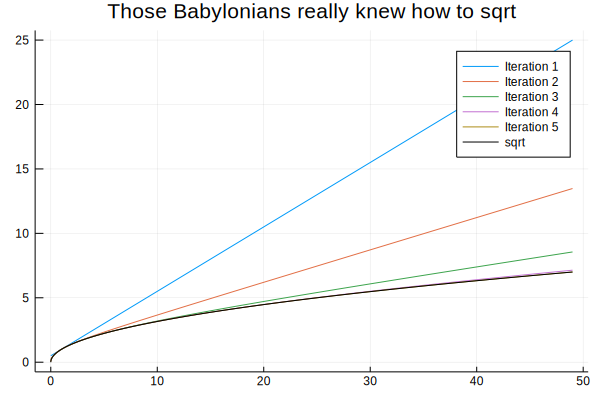

In [6]:
## Warning first plots load packages, takes time
i = 0:.01:49

plot([x->Babylonian(x,N=i) for i=1:5],i,label=["Iteration $j" for i=1:1,j=1:5])

plot!(sqrt,i,c="black",label="sqrt",
      title = "Those Babylonians really knew how to sqrt")

## ...and now the derivative, almost by magic

Eight lines of Julia!  No mention of 1/2 over sqrt(x).
D for "dual number", invented by the famous algebraist Clifford in 1873.

In [7]:
struct D <: Number  # D is a function-derivative pair
    f::Tuple{Float64,Float64}
end

Sum Rule: (x+y)' = x' + y' <br>
Quotient Rule: (x/y)' = (yx'-xy') / y^2

In [8]:
import Base: +, /, convert, promote_rule
+(x::D, y::D) = D(x.f .+ y.f)
/(x::D, y::D) = D((x.f[1]/y.f[1], (y.f[1]*x.f[2] - x.f[1]*y.f[2])/y.f[1]^2))
convert(::Type{D}, x::Real) = D((x,zero(x)))
promote_rule(::Type{D}, ::Type{<:Number}) = D

promote_rule (generic function with 159 methods)

The same algorithm with no rewrite at all computes properly
the derivative as the check shows.

In [9]:
x=49; Babylonian(D((x,1))), (√x,.5/√x)

(D((7.0, 0.07142857142857142)), (7.0, 0.07142857142857142))

In [10]:
x=π; Babylonian(D((x,1))), (√x,.5/√x)

(D((1.7724538509055159, 0.28209479177387814)), (1.7724538509055159, 0.28209479177387814))

## It just works!

How does it work?  We will explain in a moment.  Right now marvel that it does.  Note we did not
import any autodiff package.  Everything is just basic vanilla Julia.

## Symbolically

We haven't yet explained how it works, but it may be of some value to understand that the below is mathematically
equivalent, though not what the computation is doing.

Notice in the below that Babylonian works on SymPy symbols.

Note: Python and Julia are good friends.  It's not a competition!  Watch how nicely we can use the same code now with SymPy.

In [11]:
using SymPy

In [12]:
x = symbols("x")
display("Iterations as a function of x")
for k = 1:5
 display( simplify(Babylonian(x,N=k)))
end

display("Derivatives as a function of x")
for k = 1:5
 display(simplify(diff(simplify(Babylonian(x,N=k)),x)))
end

"Iterations as a function of x"

x   1
─ + ─
2   2

           2
    (x + 1) 
x + ────────
       4    
────────────
   x + 1    

 4       3       2           
x  + 28⋅x  + 70⋅x  + 28⋅x + 1
─────────────────────────────
     ⎛ 3      2          ⎞   
   8⋅⎝x  + 7⋅x  + 7⋅x + 1⎠   

 8        7         6         5          4         3         2            
x  + 120⋅x  + 1820⋅x  + 8008⋅x  + 12870⋅x  + 8008⋅x  + 1820⋅x  + 120⋅x + 1
──────────────────────────────────────────────────────────────────────────
         ⎛ 7       6        5        4        3        2           ⎞      
      16⋅⎝x  + 35⋅x  + 273⋅x  + 715⋅x  + 715⋅x  + 273⋅x  + 35⋅x + 1⎠      

 16        15          14           13             12             11          
x   + 496⋅x   + 35960⋅x   + 906192⋅x   + 10518300⋅x   + 64512240⋅x   + 2257928
──────────────────────────────────────────────────────────────────────────────
               ⎛ 15        14         13           12           11            
            32⋅⎝x   + 155⋅x   + 6293⋅x   + 105183⋅x   + 876525⋅x   + 4032015⋅x

    10              9              8              7              6            
40⋅x   + 471435600⋅x  + 601080390⋅x  + 471435600⋅x  + 225792840⋅x  + 64512240⋅
──────────────────────────────────────────────────────────────────────────────
10             9             8             7             6            5       
   + 10855425⋅x  + 17678835⋅x  + 17678835⋅x  + 10855425⋅x  + 4032015⋅x  + 8765

 5             4           3          2            
x  + 10518300⋅x  + 906192⋅x  + 35960⋅x  + 496⋅x + 1
───────────────────────────────────────────────────
    4           3         2            ⎞           


"Derivatives as a function of x"

1/2

   2            
  x  + 2⋅x + 5  
────────────────
  ⎛ 2          ⎞
4⋅⎝x  + 2⋅x + 1⎠

 6       5        4        3        2             
x  + 14⋅x  + 147⋅x  + 340⋅x  + 375⋅x  + 126⋅x + 21
──────────────────────────────────────────────────
  ⎛ 6       5       4        3       2           ⎞
8⋅⎝x  + 14⋅x  + 63⋅x  + 100⋅x  + 63⋅x  + 14⋅x + 1⎠

 14       13         12          11           10            9            8    
x   + 70⋅x   + 3199⋅x   + 52364⋅x   + 438945⋅x   + 2014506⋅x  + 5430215⋅x  + 8
──────────────────────────────────────────────────────────────────────────────
      ⎛ 14       13         12          11           10           9           
   16⋅⎝x   + 70⋅x   + 1771⋅x   + 20540⋅x   + 126009⋅x   + 440986⋅x  + 920795⋅x

        7            6            5            4           3          2       
836200⋅x  + 8842635⋅x  + 5425210⋅x  + 2017509⋅x  + 437580⋅x  + 52819⋅x  + 3094
──────────────────────────────────────────────────────────────────────────────
8            7           6           5           4          3         2       
  + 1173960⋅x  + 920795⋅x  + 440986⋅x  + 126009⋅x  + 20540⋅x  + 1771⋅x  + 70⋅x

       
⋅x + 85
───────
    ⎞  
 + 1⎠  

 30        29          28            27              26               25      
x   + 310⋅x   + 59799⋅x   + 4851004⋅x   + 215176549⋅x   + 5809257090⋅x   + 102
──────────────────────────────────────────────────────────────────────────────
                     ⎛ 30        29          28            27             26  
                  32⋅⎝x   + 310⋅x   + 36611⋅x   + 2161196⋅x   + 73961629⋅x   +

           24                  23                   22                   21   
632077611⋅x   + 1246240871640⋅x   + 10776333438765⋅x   + 68124037776390⋅x   + 
──────────────────────────────────────────────────────────────────────────────
             25                24                 23                  22      
 1603620018⋅x   + 23367042639⋅x   + 238538538360⋅x   + 1758637118685⋅x   + 957

                 20                     19                     18             
321156247784955⋅x   + 1146261110726340⋅x   + 3133113888931089⋅x   + 6614351291
──────────────────────────────────────────────────

The code is computing answers mathematically equivalent to the functions above, but not symbolically, numerically.

## How autodiff is getting the answer
Let us by hand take the "derivative" of the Babylonian iteration with respect to x. Specifically t′=dt/dx.  This is the old fashioned way of a human rewriting code.

In [13]:
function dBabylonian(x; N = 10) 
    t = (1+x)/2
    t′ = 1/2
    for i = 1:N;  
        t = (t+x/t)/2; 
        t′= (t′+(t-x*t′)/t^2)/2; 
    end    
    t′

end

dBabylonian (generic function with 1 method)

See this rewritten code gets the right answer.  So the trick is for the computer system to do it for you, and without any loss of speed or convenience.

In [14]:
x = π; dBabylonian(x), .5/√x

(0.2820947917738782, 0.28209479177387814)

What just happened?  Answer: We created an iteration by hand for t′ given our iteration for t. Then we ran the iteration alongside the iteration for t.

In [15]:
Babylonian(D(x,1))

MethodError: MethodError: no method matching D(::Irrational{:π}, ::Int64)
Closest candidates are:
  D(::Any) at In[7]:2

How did this work?  It created the same derivative iteration that we did by hand, using very general rules that are set once and need not be written by hand.

Important:: The derivative is substituted before the JIT compiler, and thus efficient compiled code is executed.

## Dual Number Notation

Instead of D(a,b) we can write a + b ϵ, where ϵ satisfies ϵ^2=0.  (Some people like to recall imaginary numbers where an i is introduced with i^2=-1.) 

Others like to think of how engineers just drop the O(ϵ^2) terms.

The four rules are

$ (a+b\epsilon) \pm (c+d\epsilon) = (a+c) \pm (b+d)\epsilon$

$ (a+b\epsilon) * (c+d\epsilon) = (ac) + (bc+ad)\epsilon$

$ (a+b\epsilon) / (c+d\epsilon) = (a/c) + (bc-ad)/d^2 \epsilon $

In [16]:
Base.show(io::IO,x::D) = print(io,x.f[1]," + ",x.f[2]," ϵ")

In [17]:
# Add the last two rules
import Base: -,*
-(x::D, y::D) = D(x.f .- y.f)
*(x::D, y::D) = D((x.f[1]*y.f[1], (x.f[2]*y.f[1] + x.f[1]*y.f[2])))

* (generic function with 394 methods)

In [18]:
D((1,0))

1.0 + 0.0 ϵ

In [19]:
D((0,1))^2

0.0 + 0.0 ϵ

In [20]:
D((2,1)) ^2

4.0 + 4.0 ϵ

In [21]:
const ϵ = D((0,1))

0.0 + 1.0 ϵ

In [22]:
ϵ * ϵ

0.0 + 0.0 ϵ

In [23]:
ϵ^2

0.0 + 0.0 ϵ

In [24]:
1/(1+ϵ)  # Exact power series:  1-ϵ+ϵ²-ϵ³-...

1.0 + -1.0 ϵ

In [25]:
(1+ϵ)^5 ## Note this just works (we didn't train powers)!!

1.0 + 5.0 ϵ

## Generalization to arbitrary roots

In [26]:
function nthroot(x, n=2; t=1, N = 10) 
    for i = 1:N;   t += (x/t^(n-1)-t)/n; end   
    t
end

nthroot (generic function with 2 methods)

In [27]:
nthroot(2,3), ∛2 # take a cube root

(1.2599210498948732, 1.2599210498948732)

In [28]:
nthroot(2+ϵ,3)

1.2599210498948732 + 0.20998684164914552 ϵ

In [29]:
nthroot(7,12), 7^(1/12)

(1.1760474285795146, 1.1760474285795146)

In [30]:
x = 2.0
nthroot( x+ϵ,3), ∛x, 1/x^(2/3)/3

(1.2599210498948732 + 0.20998684164914552 ϵ, 1.2599210498948732, 0.20998684164914552)

## Forward Diff
Now that you understand it, you can use the official package

In [31]:
using ForwardDiff

In [32]:
ForwardDiff.derivative(sqrt, 2)

0.35355339059327373

In [33]:
ForwardDiff.derivative(Babylonian, 2)

0.35355339059327373

In [34]:
@which ForwardDiff.derivative(sqrt, 2)

derivative(f::F, x::R) where {F, R<:Real} in ForwardDiff at /home/vchuravy/.julia/packages/ForwardDiff/N0wMF/src/derivative.jl:13

## Close Look at Convergence with big floats
the -log10 gives the number of correct digits.  Watch the quadratic convergence right before your eyes.

In [35]:
setprecision(3000)
round.(Float64.(log10.([Babylonian(BigFloat(2),N=k) for k=1:10] .- √BigFloat(2))), digits=3)

10-element Array{Float64,1}:
   -1.067
   -2.61 
   -5.673
  -11.797
  -24.046
  -48.544
  -97.539
 -195.53 
 -391.511
 -783.473

In [36]:
struct D1{T} <: Number  # D is a function-derivative pair
    f::Tuple{T,T}
end

In [37]:
z = D((2.0,1.0))
z1 = D1((BigFloat(2.0),BigFloat(1.0)))

D1{BigFloat}((2.0, 1.0))

In [38]:
import Base: +, /, convert, promote_rule
+(x::D1, y::D1) = D1(x.f .+ y.f)
/(x::D1, y::D1) = D1((x.f[1]/y.f[1], (y.f[1]*x.f[2] - x.f[1]*y.f[2])/y.f[1]^2))
convert(::Type{D1{T}}, x::Real) where {T} = D1((convert(T, x), zero(T)))
promote_rule(::Type{D1{T}}, ::Type{S}) where {T,S<:Number} = D1{promote_type(T,S)}

promote_rule (generic function with 172 methods)

In [39]:
A = randn(3,3)

3×3 Array{Float64,2}:
 1.37045   -0.643011   0.724133
 0.703602   2.38024   -0.710846
 1.80605   -0.183849  -0.183281

In [40]:
x = randn(3)

3-element Array{Float64,1}:
 -0.21100379585385595
 -1.3193622612868683 
  0.07359791104176393

In [41]:
ForwardDiff.gradient(x->x'A*x,x)

3-element Array{Float64,1}:
 -0.47206412148676  
 -6.359440684883736 
  0.6195697137928886